In [310]:
import numpy as np
from scipy.signal import resample_poly
import matplotlib.pyplot as plt
from scipy.signal import correlate
from scipy.signal import find_peaks
from PIL import Image

In [312]:
envelope = np.load('AM_demodulated_LO_signal.npy')
t = np.load('t_LO_signal.npy')
frame_rate = 11025

In [314]:
frame_width = int(0.5 * frame_rate)
bits_width = 2080
samples_per_bit = frame_width / bits_width
samples_per_bit = int(round(samples_per_bit))
print(samples_per_bit)

3


In [316]:
sample_rate = (samples_per_bit * bits_width) / 0.5
sample_rate = int(sample_rate)
print(sample_rate)

12480


In [318]:
from fractions import Fraction

up = Fraction(sample_rate, frame_rate).numerator
down = Fraction(sample_rate, frame_rate).denominator
print(up)
print(down)

832
735


In [319]:
envelope_resampled = resample_poly(envelope, up, down)
print(envelope_resampled)
frame_width=int(0.5*sample_rate)
print(frame_width)

[0.35901538 0.4958833  0.54681851 ... 0.45414299 0.53341106 0.20886822]
6240


In [322]:
sync_a_bits = '000011001100110011001100110011000000000'
sync_b_bits = '000011100111001110011100111001110011100'

In [323]:
sync_a_amplitude = [0 if bit == '0' else 1 for bit in sync_a_bits]
sync_b_amplitude = [0 if bit == '0' else 1 for bit in sync_b_bits]

sync_a_signal = np.repeat(sync_a_amplitude, samples_per_bit)
sync_b_signal = np.repeat(sync_b_amplitude, samples_per_bit)

In [324]:
signal_norm = (envelope_resampled - np.mean(envelope_resampled)) / np.std(envelope_resampled)

In [328]:
sync_a_norm = (sync_a_signal - np.mean(sync_a_signal)) / np.std(sync_a_signal)
sync_b_norm = (sync_b_signal - np.mean(sync_b_signal)) / np.std(sync_b_signal)

In [329]:
correlation_a = correlate(signal_norm, sync_a_norm, mode='valid')
correlation_b = correlate(signal_norm, sync_b_norm, mode='valid')

In [330]:
min_distance = int(0.9 * 0.25 * frame_rate)

In [331]:
threshold_a = 0.6 * np.max(correlation_a)
threshold_b = 0.6 * np.max(correlation_b)

In [333]:
peaks_a, _ = find_peaks(correlation_a, height=threshold_a, distance=min_distance)
peaks_b, _ = find_peaks(correlation_b, height=threshold_b, distance=min_distance)

In [336]:
print("Liczba pików Sync A:", len(peaks_a))
print("Liczba pików Sync B:", len(peaks_b))

Liczba pików Sync A: 124
Liczba pików Sync B: 137


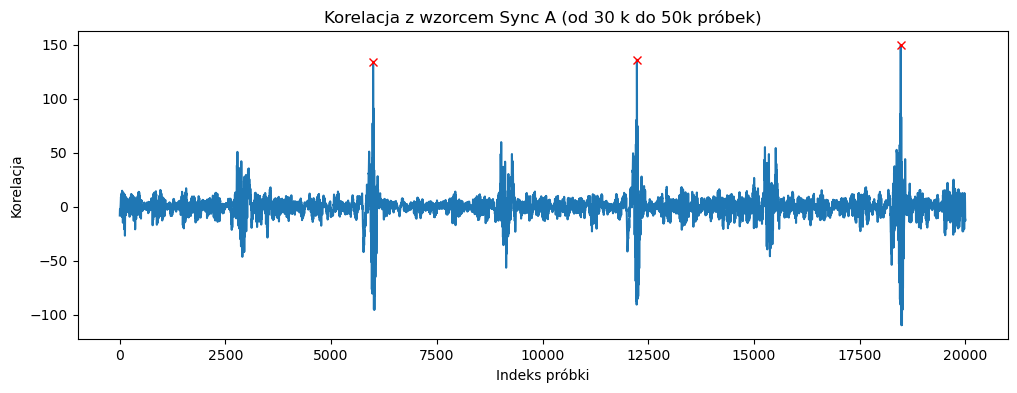

In [338]:
start_idx = 30000
end_idx = 50000
correlation_a_segment = correlation_a[start_idx:end_idx]
peaks_a_segment = peaks_a[(peaks_a >= start_idx) & (peaks_a < end_idx)] - start_idx


plt.figure(figsize=(12, 4))
plt.plot(correlation_a_segment)
plt.plot(peaks_a_segment, correlation_a_segment[peaks_a_segment], 'rx')
plt.title('Korelacja z wzorcem Sync A (od 30 k do 50k próbek)')
plt.xlabel('Indeks próbki')
plt.ylabel('Korelacja')
plt.show()

In [276]:
first_sync_a_position = peaks_a[0]

In [278]:
aligned_signal = envelope_resampled[first_sync_a_position:]

In [280]:
num_lines = len(aligned_signal) // frame_width
signal = aligned_signal[:num_lines * frame_width]

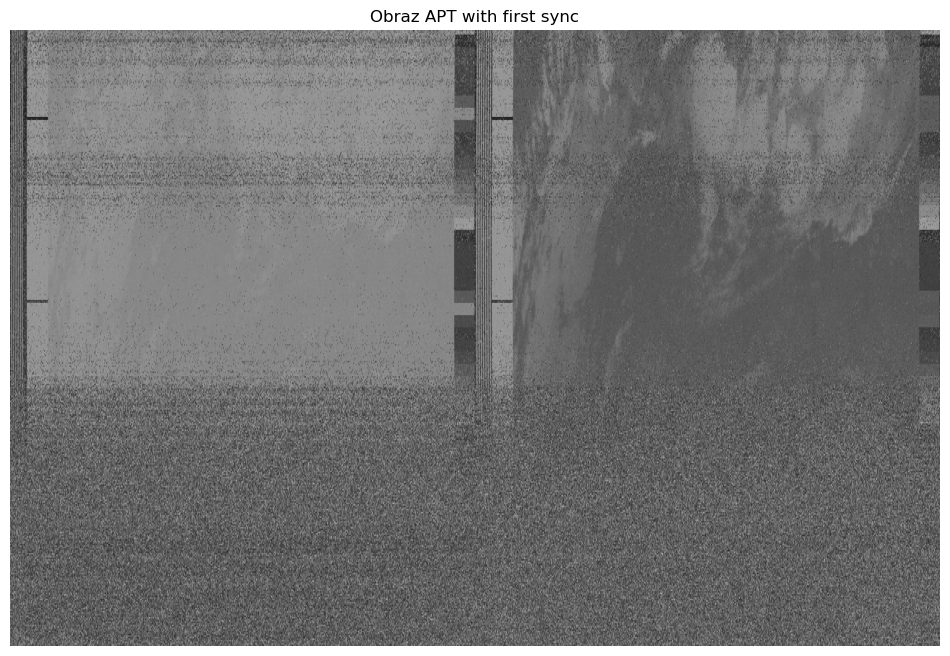

In [285]:
signal_min = np.min(signal)
signal_max = np.max(signal)
signal_normalized = ((signal - signal_min) / (signal_max - signal_min) * 255).astype(np.uint8)
image_array = signal_normalized.reshape((num_lines, frame_width))
image = Image.fromarray(image_array, mode='L')

plt.figure(figsize=(12, 8))
plt.imshow(image, cmap='gray', aspect='auto')
plt.title('Obraz APT with first sync')
plt.axis('off')

plt.show()

In [289]:
segment_lengths_bits = {
    'sync_a': 39,
    'space_a': 47,
    'image_a': 909,
    'telemetry_a': 45,
    'sync_b': 39,
    'space_b': 47,
    'image_b': 909,
    'telemetry_b': 45
}

In [291]:
segment_lengths_samples = {key: val * samples_per_bit for key, val in segment_lengths_bits.items()}
total_segment_samples = sum(segment_lengths_samples.values())

print("Suma długości segmentów w próbkach:", total_segment_samples)
print("Liczba próbek na linię (frame_width):",frame_width)

Suma długości segmentów w próbkach: 6240
Liczba próbek na linię (frame_width): 6240


In [293]:
segments = {}
current_idx = 0
for key in segment_lengths_bits.keys():
    segments[key + '_start'] = int(current_idx)
    current_idx += segment_lengths_samples[key]
    segments[key + '_end'] = int(current_idx)

In [295]:
image_a_data = []
image_b_data = []

In [297]:
length_a = segments['telemetry_a_end'] - segments['sync_a_start']
print("Długość linii dla kanału A:", length_a)

length_b = segments['telemetry_b_end'] - segments['sync_b_start']
print("Długość linii dla kanału B:", length_b)

Długość linii dla kanału A: 3120
Długość linii dla kanału B: 3120


In [299]:
for i in range(num_lines):
    line_start = i * frame_width
    line_end = line_start + frame_width
    line = signal[line_start:line_end]
    
    line_a = line[segments['sync_a_start']:segments['telemetry_a_end']]
    image_a_data.append(line_a)
    
    line_b = line[segments['sync_b_start']:segments['telemetry_b_end']]
    image_b_data.append(line_b)

In [301]:
image_a_array = np.array(image_a_data)
image_b_array = np.array(image_b_data)

In [303]:
image_a_min = np.min(image_a_array)
image_a_max = np.max(image_a_array)
image_a_normalized = ((image_a_array - image_a_min) / (image_a_max - image_a_min) * 255).astype(np.uint8)

image_b_min = np.min(image_b_array)
image_b_max = np.max(image_b_array)
image_b_normalized = ((image_b_array - image_b_min) / (image_b_max - image_b_min) * 255).astype(np.uint8)

In [304]:
image_a = Image.fromarray(image_a_normalized, mode='L')
image_b = Image.fromarray(image_b_normalized, mode='L')

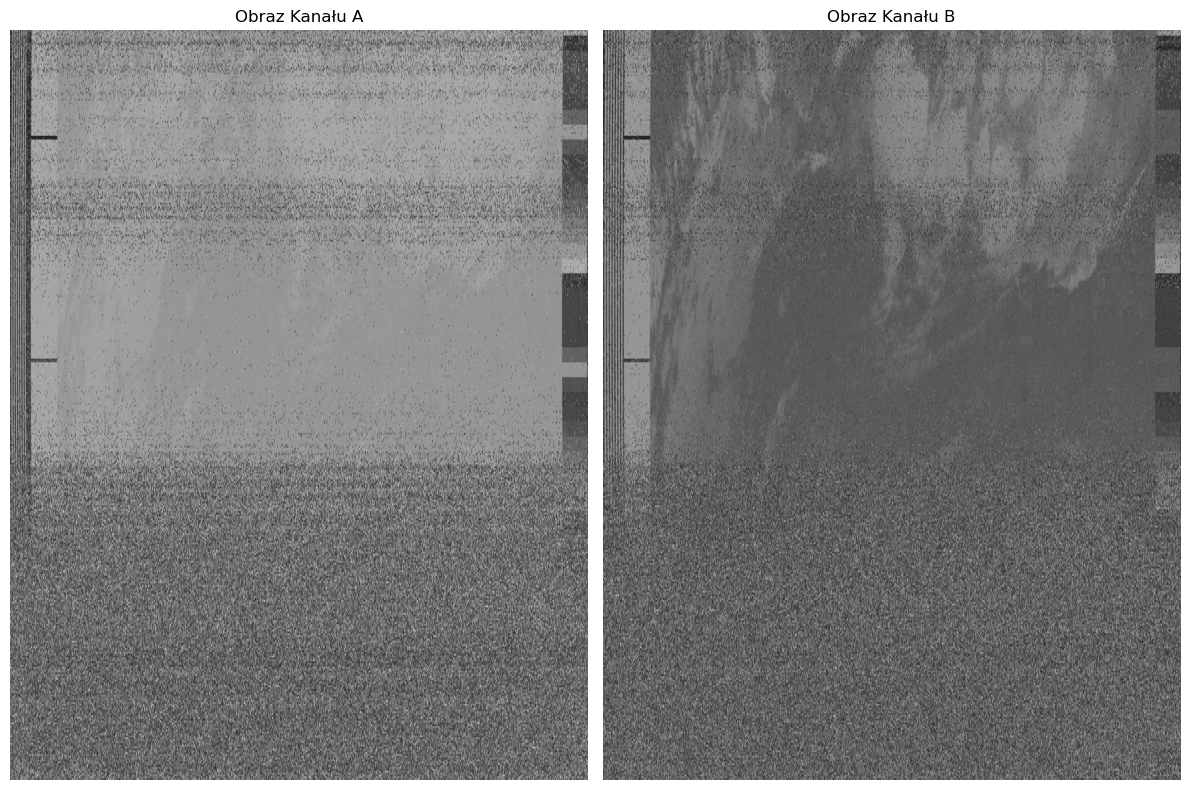

In [307]:
plt.figure(figsize=(12, 8))

plt.subplot(1, 2, 1)
plt.imshow(image_a, cmap='gray', aspect='auto')
plt.title('Obraz Kanału A')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(image_b, cmap='gray', aspect='auto')
plt.title('Obraz Kanału B')
plt.axis('off')

plt.tight_layout()
plt.show()

In [121]:
image_A_data = []
image_B_data = []

for i in range(num_lines):
    line_start = i * frame_width
    line_end = line_start + frame_width
    line = signal[line_start:line_end]
    
    line_a = line[segments['image_a_start']:segments['image_a_end']]
    image_A_data.append(line_a)
    
    line_b = line[segments['image_b_start']:segments['image_b_end']]
    image_B_data.append(line_b)

image_A_array = np.array(image_A_data)
image_B_array = np.array(image_B_data)

In [123]:
image_A_min = np.min(image_A_array)
image_A_max = np.max(image_A_array)
image_A_normalized = ((image_A_array - image_A_min) / (image_A_max - image_A_min) * 255).astype(np.uint8)

image_B_min = np.min(image_B_array)
image_B_max = np.max(image_B_array)
image_B_normalized = ((image_B_array - image_B_min) / (image_B_max - image_B_min) * 255).astype(np.uint8)

In [125]:
image_A = Image.fromarray(image_A_normalized, mode='L')
image_B = Image.fromarray(image_B_normalized, mode='L')

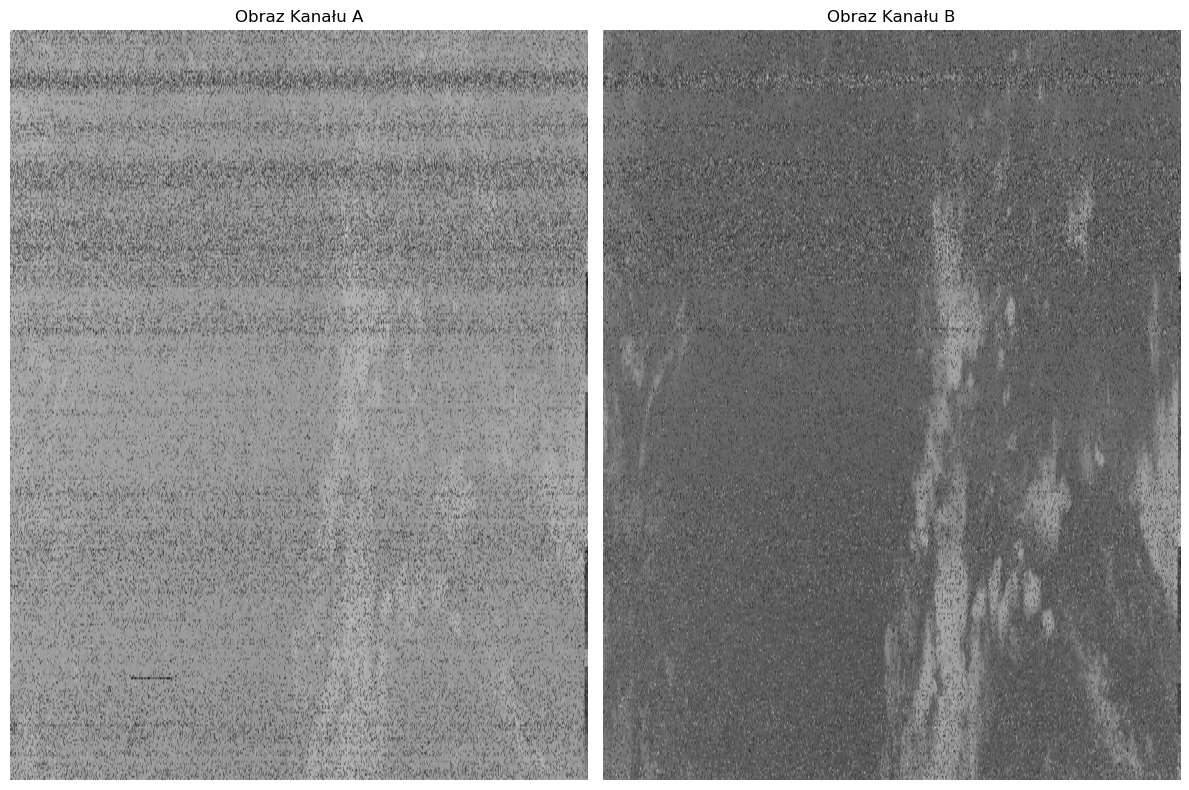

In [127]:
plt.figure(figsize=(12, 8))

plt.subplot(1, 2, 1)
plt.imshow(image_A, cmap='gray', aspect='auto')
plt.title('Obraz Kanału A')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(image_B, cmap='gray', aspect='auto')
plt.title('Obraz Kanału B')
plt.axis('off')

plt.tight_layout()
plt.show()